<a href="https://colab.research.google.com/github/pioneerbluepanthers/computationaldrug/blob/main/rohit_comparing_binarization_effects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
! pip install shap

In [7]:
# data science
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score
import keras
from sklearn import svm

# figure generation
import matplotlib.pyplot as plt

# machine learning
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import xgboost as xgb
import shap

In [8]:
# mount local drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
#read social data file
base_df = pd.read_csv("/content/drive/MyDrive/Rohit Work/social_data.csv", index_col=0)

In [ ]:
base_df.head()

In [ ]:
base_df.sample

# Data processing

In [10]:
# KNN imputation

def KNNImputation(df):
  #df_col_f=['patient_id']
  df_col = list(df.columns)
  df_index = df.index

  # initialize KNN imputer with 2 neighbors
  imputer=KNNImputer(n_neighbors=2)
  # make a copy of input dataframe
  temp_df = df.copy()
  # change the index to numerical values
  temp_df.reset_index(inplace=True)
  temp_df.drop(columns=temp_df.columns[0], inplace=True)
  #Compute KNN fit transform to impute the data
  new_temp_df = pd.DataFrame(imputer.fit_transform(temp_df.reset_index()))
  #drop the extra first column
  new_temp_df.drop(columns=new_temp_df.columns[0], inplace=True)
  #set the column and index values
  new_temp_df.columns=df_col
  new_temp_df.index = df_index
  imputed_df=new_temp_df.copy()
  #sort the dataframe columns in alphbetical order
  imputed_df=imputed_df.reindex(sorted(imputed_df.columns), axis=1)

  return imputed_df

In [ ]:
# Simple Imputer

def ComorbidImputationSimple(df):
   df_col = list(df.columns)
   imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
   imputed_df = pd.DataFrame(imputer.fit_transform(df))
   imputed_df.columns=df_col
   imputed_df.index=df.index
   #print(imputed_df)

   return imputed_df



In [ ]:
# Iterative Imputer

def ComorbidImputationIterative(df):
  df_col = list(df.columns)
  imputer = IterativeImputer(random_state=0)
  imputed_df = pd.DataFrame(imputer.fit_transform(df))
  imputed_df.columns=df_col
  imputed_df.index=df.index
  #print(imputed_df)
  return imputed_df


In [11]:
from pandas.core.computation.pytables import com
# binarize comorbidities

# use: simply pass in the sociodemographic (or with binarized social risk factors)
# data frame. The function will return another dataframe containing all other
# relevant information and binarized comorbidities

def BinarizeComorbidities(df, column="comorbidity"):
  # get list of unique entries
  entries = df.loc[:, column].unique()

  # get unique list of conditions
  conditions = []
  for i in entries:
    try:
      subList = i.split(", ")
      for k in subList:
        conditions.append(k)
    except:
      pass


  uniqueConditions = list(set(conditions))

  # set up sub_df (to be appended) - columns are each condition
  comor_df = pd.DataFrame(index=df.index, columns=uniqueConditions, data=0)

  # populate the df with binary (0 = no, 1 = yes)
  for patient in df.index:
    comorbidity = df.loc[patient, "comorbidity"]
    try:
      comorbidityList = comorbidity.split(", ")
      for i in comorbidityList:
        comor_df.loc[patient, i] = 1
    except:
      for i in comor_df.columns:
        comor_df.loc[patient, i] = np.nan

  # remove comorbidity from original df
  concat_df = df.copy()
  concat_df.drop(columns=["comorbidity"], inplace=True)


  #copy it temp variable
  temp_df = comor_df.copy()
  #impute the missing values - using KNN imputation
  comor_temp = KNNImputation(temp_df)
  #comor_temp = ComorbidImputationSimple(temp_df)
  #comor_temp = ComorbidImputationIterative(temp_df)
  # concatenate the dfs
  #fin_df = pd.concat([concat_df, comor_df], axis=1)
  fin_df = pd.concat([concat_df, comor_temp], axis=1)

  # return the final df
  return fin_df

In [12]:
# binarize social risk factors

# use: simply pass in the sociodemographic (or with binarized comorbidities)
# data frame. The function will return another dataframe containing all other
# relevant information and binarized comorbidities

def BinarizeSocialRisk(df, column="social_risk_factors"):
  # get list of unique entries
  entries = df.loc[:, column].unique()

  # get unique list of conditions
  conditions = []
  for i in entries:
    try:
      subList = i.split(", ")
      for k in subList:
        conditions.append(k)
    except:
      pass


  uniqueConditions = list(set(conditions))

  # set up sub_df (to be appended) - columns are each condition
  socialRisk_df = pd.DataFrame(index=df.index, columns=uniqueConditions, data=0)

  # populate the df with binary (0 = no, 1 = yes)
  for patient in df.index:
    socialRisk = df.loc[patient, column]
    try:
      socialRiskList = socialRisk.split(", ")
      for i in socialRiskList:
        socialRisk_df.loc[patient, i] = 1
    except:
      for i in socialRisk_df.columns:
        socialRisk_df.loc[patient, i] = np.nan

  # remove comorbidity from original df
  concat_df = df.copy()
  concat_df.drop(columns=[column], inplace=True)
  #copy it temp variable
  temp_df = socialRisk_df.copy()
  #impute the missing values - using KNN imputation
  sociRisk_temp = KNNImputation(temp_df)
  # concatenate the dfs
  #fin_df = pd.concat([concat_df, socialRisk_df], axis=1)
  fin_df = pd.concat([concat_df, sociRisk_temp], axis=1)

  # return the final df
  return fin_df

In [15]:
# Get X and y data for Comorbidity, Social or both
def GetXyData(base_df, datatype):
  como_start_col=' TNF-α antagonists'
  como_end_col='cytostatics'
  so_start_col='Current smoker'
  so_end_col='refugees'
  comoStr = 'co_mo'
  socStr='so_r'

  if datatype == comoStr:
    #get binarized comorbidity data
    bindata = BinarizeComorbidities(base_df)
    #select the X values using start and end columns
    X=bindata.loc[:,como_start_col:como_end_col]
    #select outcome as the y
    y=bindata['outcome']
  elif datatype == socStr:
    bindata = BinarizeSocialRisk(base_df)
    #select the X values using start and end columns
    X=bindata.loc[:,so_start_col:so_end_col]
    #select outcome as the y
    y=bindata['outcome']
    #display(bindata.columns)
  else:
    X=[]
    y=[]
  return (X,y)

In [16]:
#Get binarized comorbidity data
#bincomorbid_df = BinarizeComorbidities(base_df)
#comoStr = 'co_mo'
comoStr = 'so_r'
X, y = GetXyData(base_df, comoStr)

In [ ]:
#display(bincomorbid_df[bincomorbid_df.HIV.between(0,1, inclusive='neither')])
#display(bincomorbid_df.columns)
#display(X.columns)
#display(bincomorbid_df.loc[:,'outcome':'Anemia'])

In [ ]:
#X=bincomorbid_df.loc[:,' TNF-α antagonists':'cytostatics']
#y=bincomorbid_df['outcome']
#display(X.columns)

In [17]:
#split data into train (80%) and test (20%). random_state value ensures output is always the same
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=44)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
#normalize input data
X_train = normalize(X_train)
X_test = normalize(X_test)
#label encode outcome data
le=LabelEncoder()
trainY=le.fit_transform(y_train)
testY=le.fit_transform(y_test)


In [19]:
# converting dataset into DMatrix for XGBoost
dm_train = xgb.DMatrix(X_train, trainY)
dm_test = xgb.DMatrix(X_test, testY)

In [ ]:
lbinarizer = LabelBinarizer()
trainY = lbinarizer.fit_transform(y_train)
testY = lbinarizer.transform(y_test)

# Figure Generation

# Machine Learning

In [20]:
# ROC Curve Generation

# input testing outcomes, testing data frame, and trained model. Displays a graph
# of the ROC curve to show specificity and sensitivity

def ROCCurve(y_test, X_test, model):
  # generate probability predictions
  y_probs = model.predict_proba(X_test)[:,1]
  # generate no skill probabilities
  noSkill = [0] * len(y_test)
  # generate no skill and model curves
  model_fpr, model_tpr, _ = roc_curve(y_test, y_probs) # from sklearn.metrics
  noSkill_fpr, noSkill_tpr, _ = roc_curve(y_test, noSkill)
  # make graph
  fig, ax = plt.subplots(figsize=(9,6))
  ax.plot(model_fpr, model_tpr, c='tab:red', label="model", marker="o")
  ax.plot(noSkill_fpr, noSkill_tpr, c='cornflowerblue', label="no skill",
          linestyle='--')
  ax.set_xlabel("False Positive Rate")
  ax.set_ylabel("True Positive Rate")
  plt.legend()
  plt.show()

In [21]:
# Model Metrics

# pass in test data, test outcomes, and trained model. Return MCC, AUC, F1,
# Sensitivity, specificity, accuracy

def ModelMetrics(X_test, y_test, model):
  # make prediction and get confusion matrix
  y_pred = model.predict(X_test)
  confusion = confusion_matrix(y_test, y_pred) # from sklearn.metrics
  TP = confusion[1,1] # true positive
  TN = confusion[0,0] # true negative
  FP = confusion[0,1] # false positive
  FN = confusion[1,0] # false negative

  # calculate the accuracy
  acc = (TP+TN)/(TP+FP+FN+TN)
  print(f"the accuracy is: {acc}")

  # calculate sensitivity
  sens = TP/(TP+FN)
  print(f"the accuracy is: {sens}")

  # calculate specificity
  spec = TN/(TN+FP)
  print(f"the specificity is: {spec}")

  # calculate F1
  f1 = f1_score(y_test, y_pred) # from sklearn.metrics
  print(f"the f1 is: {f1}")

  # calculate MCC
  MCC = matthews_corrcoef(y_test, y_pred) # from sklearn.metrics
  print(f"the MCC is: {MCC}")

  # Calculate AUC
  # generate probability predictions
  y_probs = model.predict_proba(X_test)[:,1]
  AUC = roc_auc_score(y_test, y_probs) # from sklearn.metrics
  print(f"the AUC is: {AUC}")

In [22]:
# SHAP tree explainer

# input x_train df, the IN ORDER column names of that df, and the TRAINED model
# A graph will be displayed to the screen which shows feature importance in
# order

def TreeExplainer(X_train, columnNames, model):
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(X_train)
  shap.summary_plot(shap_values, features=X_train, feature_names=columnNames)

In [23]:
# SHAP Kernel Explainer

def KernelExplainer(X_train, X_test, columnNames, model):
  #explainer = shap.KernelExplainer(model.predict_proba, X_train, nsamples=100, link='logit')
  explainer = shap.KernelExplainer(model.predict_proba, X_train)
  shap_values = explainer.shap_values(X_test)
  shap.summary_plot(shap_values, features=X_test.iloc[0,:], feature_names=columnNames)

In [24]:

# Get the model for RandomForest Classifier
# inputs are X and Y training values

def GetRandomForestModel(X,y):
  rf_model = RandomForestClassifier(n_estimators=50, max_features='sqrt', random_state=44)
  #rf_model.fit(X_train, y_train)
  rf_model.fit(X, y)
  return rf_model

In [25]:
# Predict the values based on model
# inputs are test values and the model
def RandomForestPredict(x_test, model):
  pred = model.predict(x_test)
  return pred


In [26]:
# Get the model for SVM Classifier
# inputs are X and Y training values
def GetSVMModel(X,y):
  #select the linear kernel
  svm_model = svm.SVC(kernel='linear', probability=True)
  svm_model.fit(X, y)
  return (svm_model)

In [27]:
# Get the KNN classifier model
def GetKNNModel(X,y):
  neighbor = 5
  knn_model = KNeighborsClassifier(n_neighbors=neighbor)
  knn_model.fit(X,y)
  return knn_model

In [53]:
def GetFeedForwardModel():
  model = Sequential()
  #model.add(Flatten())
  #model.add(Dense(256, input_shape=(X_train.shape[1],), activation="sigmoid"))
  #model.add(Dense(10, input_shape=(X_train.shape[1],), activation="sigmoid"))
  model.add(Dense(32, input_shape=(X_train.shape[1],), activation="relu"))
  model.add(Dense(16,  activation="relu"))
  model.add(Dense(1, activation="sigmoid"))
  #model.add(Dense(1, activation="softmax"))
  return model

In [54]:
def GetFeedForwardModelRelu():
  model = Sequential()
  #model.add(Flatten())
  model.add(Dense(256, input_shape=(X_train.shape[1],), activation="relu"))
  #model.add(Dense(128, activation="relu"))
  model.add(Dense(1, activation="softmax"))
  return model

In [44]:
#XGBoost model generation
def GetXGBoostModel():
  # use tree method and gpu acceleration
  #params = {'objective':'reg:squarederror','tree_method':'gpu_hist'}
  #params = {'objective':'multi:softprob','tree_method':'gpu_hist','num_class':2}

  paramsg = {'objective':'binary:logistic','tree_method':'gpu_hist','max_depth':3,'eta':0.1}
  params = {'objective':'binary:logistic','tree_method':'hist','max_depth':3,'eta':0.1}
  evals={(dm_train,'train'),(dm_test,'test')}
  #set number of boost rounds
  n=500
  #set the early stopping rounds
  es=50
  #model = xgb.train (params=params, num_boost_round=n, dtrain=dm_train, early_stopping_rounds=es)
  try:
    model = xgb.train (params=paramsg, num_boost_round=n, dtrain=dm_train)
  except:
    model = xgb.train (params=params, num_boost_round=n, dtrain=dm_train)
  return model

In [47]:
#XGBoost model classification
def GetXGBoostCVModel():
  # use tree method and gpu acceleration
  #params = {'objective':'reg:squarederror','tree_method':'gpu_hist'}
  #params = {'objective':'binary:logistic','tree_method':'gpu_hist','num_class':2}
  params = {'objective':'multi:softprob','tree_method':'hist','num_class':2}
  paramsg = {'objective':'multi:softprob','tree_method':'gpu_hist','num_class':2}
  #set number of boost rounds
  n=100
  #set the early stopping rounds
  es=50
  #model = xgb.train (params=params, num_boost_round=n, dtrain=dm_train, early_stopping_rounds=es)

  try:
    model = xgb.cv(params=paramsg, num_boost_round=n, dtrain=dm_train, nfold=5, metrics=['mlogloss','auc','merror'])
  except:
    model = xgb.cv(params=params, num_boost_round=n, dtrain=dm_train, nfold=5, metrics=['mlogloss','auc','merror'])

  return model

In [32]:
# print the model accuracy
# Input: Model, X test and Y test; Output: Accuracy as a % value
def PrintModelAccuracy(model, X_test, testY):
  # predict results
  pred = model.predict(X_test)
  try:
    #round the prediction probabilities
    predictions = [round(value) for value in pred]
  except:
    pred_encode = le.fit_transform(pred)
    predictions = [round(value) for value in pred_encode]
  # score the accuracy
  accuarcy = accuracy_score(testY, predictions)
  # display as a percentage
  print('Accuracy: %.2f%%'%(accuarcy *100.0))

# Testing
- keep empty when not in use

In [33]:
#train model and predict results; used 80/20 split for train/test
modelrf=GetRandomForestModel(X,y)
predictions = RandomForestPredict(X_test, modelrf)
#display(pd.DataFrame(predictions))
#print('Y TEST')
#display(y_test)
importances = modelrf.feature_importances_
columns = X.columns
i=0
#display contributions of each feature in the prediction; Similar results as Awanti's paper though I get
# Anemia, HIV and Diabetes (ignoring None/Other) as opposed to Anemia, HIV, Hepatitis in Awanti's paper
while (i<len(columns)):
  print (f"Importance of Feature '{columns[i]}' is {round(importances[i]*100,2)}%")
  i+=1

Importance of Feature 'Current smoker' is 13.07%
Importance of Feature 'Documented MDR contact' is 7.1%
Importance of Feature 'Ex prisoner' is 11.69%
Importance of Feature 'Homeless' is 9.26%
Importance of Feature 'Immigrants' is 1.1%
Importance of Feature 'Patient alcohol abuse' is 27.08%
Importance of Feature 'Patient alcohol abuse not available/unknown' is 4.31%
Importance of Feature 'Patient drug abuse' is 15.6%
Importance of Feature 'Patient smoking data not available/unknown' is 1.88%
Importance of Feature 'TB care worker' is 1.89%
Importance of Feature 'Worked abroad' is 4.75%
Importance of Feature 'internal migrants' is 1.06%
Importance of Feature 'refugees' is 1.22%


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [34]:
PrintModelAccuracy(modelrf, X_test, testY)

Accuracy: 80.67%


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


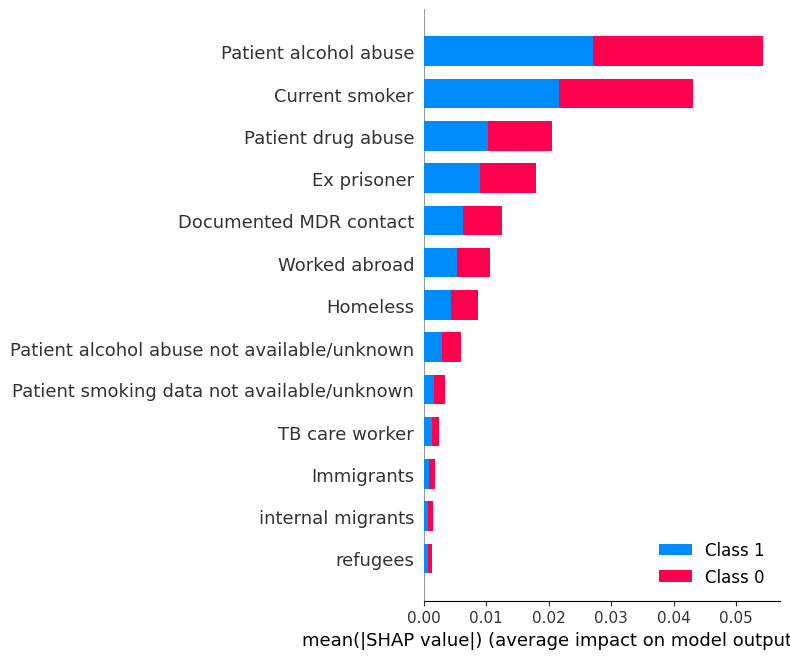

In [35]:
TreeExplainer(X_train,X.columns, modelrf)

In [36]:
model_svm =GetSVMModel(X_train, trainY)

In [40]:
#KernelExplainer(X_train,X_test, X.columns, model_svm)

In [37]:
PrintModelAccuracy(model_svm, X_test, testY)

Accuracy: 80.61%


In [38]:
model_knn = GetKNNModel(X_train,trainY)

In [39]:
PrintModelAccuracy(model_knn, X_test, testY)

Accuracy: 74.28%


In [ ]:
#TreeExplainer(X_train,X.columns, model_knn)
KernelExplainer(X_train,X_test, X.columns, model_knn)

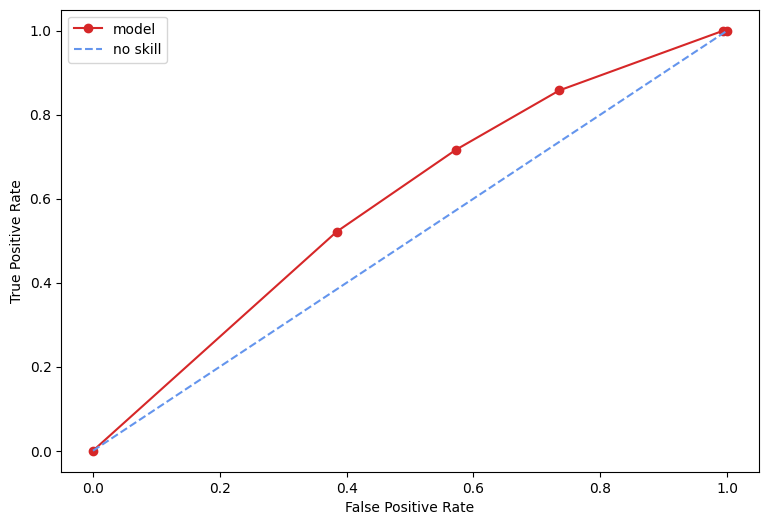

In [40]:
ROCCurve(testY, X_test, model_knn)

In [ ]:
checkpoint = ModelCheckpoint(filepath="/content/drive/MyDrive/Rohit Work/fnn_model_sgd", monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [55]:

sgd = SGD(0.1)
model=GetFeedForwardModel()
model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"] )
modelrelu=GetFeedForwardModelRelu()
modelrelu.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])
modelreluadam = GetFeedForwardModelRelu()
modelreluadam.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])
model.summary()
modelrelu.summary()
modelreluadam.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               3584      
                                                                 
 dense_4 (Dense)             (None, 

In [56]:
#hist = model.fit(X_train, trainY, validation_data=(X_test, testY), epochs=20,batch_size=64,callbacks=[checkpoint, early])
hist = model.fit(X_train, trainY, epochs=10,batch_size=16)

Epoch 1/10
419/419 [==============================] - 2s 2ms/step - loss: 0.4977 - accuracy: 0.7993
Epoch 2/10
419/419 [==============================] - 1s 2ms/step - loss: 0.4911 - accuracy: 0.8037
Epoch 3/10
419/419 [==============================] - 1s 2ms/step - loss: 0.4901 - accuracy: 0.8037
Epoch 4/10
419/419 [==============================] - 1s 2ms/step - loss: 0.4895 - accuracy: 0.8037
Epoch 5/10
419/419 [==============================] - 1s 2ms/step - loss: 0.4889 - accuracy: 0.8037
Epoch 6/10
419/419 [==============================] - 1s 2ms/step - loss: 0.4893 - accuracy: 0.8037
Epoch 7/10
419/419 [==============================] - 1s 2ms/step - loss: 0.4888 - accuracy: 0.8037
Epoch 8/10
419/419 [==============================] - 1s 2ms/step - loss: 0.4883 - accuracy: 0.8037
Epoch 9/10
419/419 [==============================] - 1s 2ms/step - loss: 0.4874 - accuracy: 0.8037
Epoch 10/10
419/419 [==============================] - 1s 2ms/step - loss: 0.4875 - accuracy: 0.8037

In [ ]:
histrelu = modelrelu.fit(X_train, trainY, validation_data=(X_test, testY), epochs=20,batch_size=10)

In [ ]:
histreluadam = modelreluadam.fit(X_train, trainY, validation_data=(X_test, testY), epochs=20,batch_size=10)

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Val Acc", "loss", "Val Loss"])
plt.show()

53/53 [==============================] - 0s 2ms/step - loss: 0.4832 - accuracy: 0.8061
Training accuracy: 0.8037313222885132
Testing accuracy: 0.8060859441757202


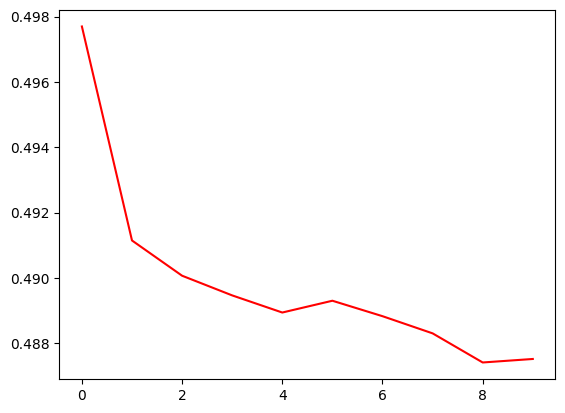

In [58]:
train_acc = model.evaluate(X_train, trainY, batch_size=32)[1]
test_acc = model.evaluate(X_test, testY, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = hist.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.show()

In [59]:
#ModelMetrics(X_test, testY, model)

#predsigmoid = (model.predict(X_test)>0.5).astype(int)
#predrelu=(modelrelu.predict(X_test)>0.5).astype(int)
#modelsigmoid = load_model('/content/drive/MyDrive/Rohit Work/fnn_model')
#predsigmoid = modelsigmoid.predict(X_test)
predsigmoid = model.predict(X_test)
predrelu = modelrelu.predict(X_test)
predreluadam = modelreluadam.predict(X_test)

for i in range (10):
  print(testY[i],predsigmoid[i],predrelu[i], predreluadam[i])


53/53 [==============================] - 0s 1ms/step
1 [0.80983526] [0.99999994] [0.99999994]
0 [0.7183195] [0.99999994] [0.99999994]
1 [0.80983526] [0.99999994] [0.99999994]
1 [0.7183195] [0.99999994] [0.99999994]
1 [0.83879334] [0.99999994] [0.99999994]
1 [0.8112857] [0.99999994] [0.99999994]
1 [0.80983526] [0.99999994] [0.99999994]
0 [0.80983526] [0.99999994] [0.99999994]
1 [0.80983526] [0.99999994] [0.99999994]
0 [0.74342227] [0.99999994] [0.99999994]


In [45]:
modelnativepred = GetXGBoostModel()

[19:51:11] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1


In [46]:
PrintModelAccuracy(modelnativepred, dm_test, testY)

Accuracy: 80.61%


In [52]:
#Predictions using native XGBoost
modelnativecv = GetXGBoostCVModel()
print(modelnativecv['test-auc-mean'].max())

[19:57:24] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1
0.6105032435122209


In [ ]:
#predictions using sklearn XGBoost
try:
  x_class = xgb.XGBClassifier(n_estimators=500,
                              objective='binary:logistic',
                              tree_method='gpu_hist',
                              eta=0.1,
                              max_depth=3)
except:
  x_class = xgb.XGBClassifier(n_estimators=500,
                              objective='binary:logistic',
                              tree_method='hist',
                              eta=0.1,
                              max_depth=3)
x_class.fit(X_train, trainY)
modelsc = x_class.get_booster()

In [39]:
PrintModelAccuracy(modelsc, dm_test, testY)

Accuracy: 79.95%


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


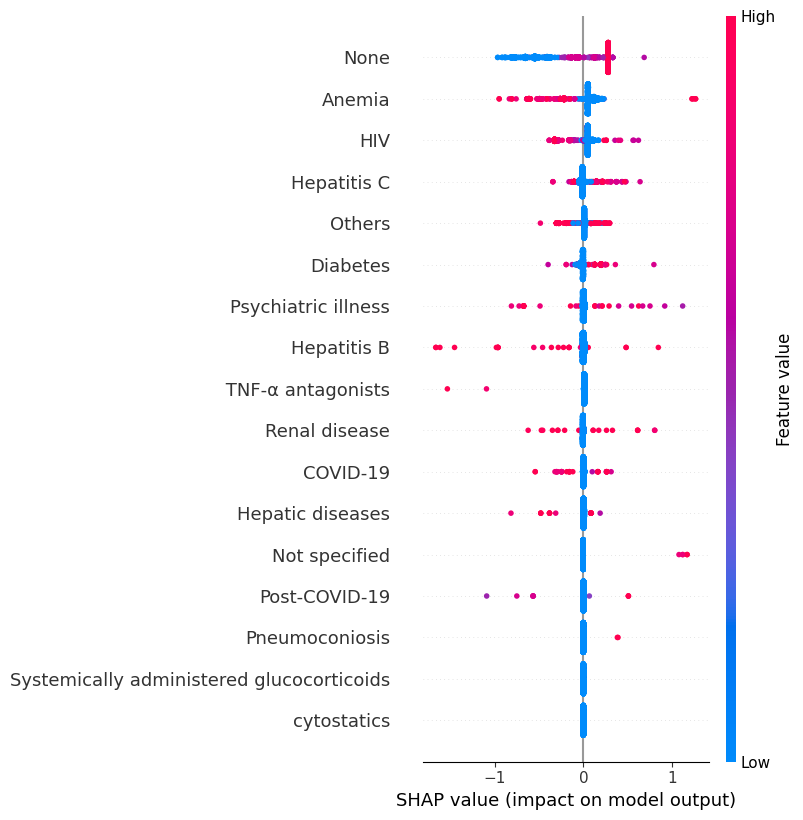

In [37]:
#display(X.columns)
TreeExplainer(X_test,X.columns, modelsc)